**Chapter 9 – Unsupervised Learning**

# Setup

The regular requirements as in previous notebooks

In [47]:
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 10)
assert version.parse(sklearn.__version__) >= version.parse("1.2.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Common imports
import numpy as np
import os

In [48]:
sklearn.__version__

'1.7.1'

> Version 1.2.2 of sklearn is absolutely necessary for this chapter.    
> If your version is not sufficient then upgrade through `pip install --upgrade scikit-learn`. 

# Unsupervised learning

Most of the applications of machine learning today are based on supervised
learning (and as a result, this is where most of the investments go to).     
The vast majority of the available data however is unlabeled: we have the input features X, but we do not have the labels y.    

Let's assume you want to setup a quality assurance system on a manufacturing production line.   
You want to create a system that will take a few pictures of each item on a
manufacturing production line and detect which items are defective. You can fairly
easily create a system that will take pictures automatically, and this might give you
thousands of pictures every day. You can then build a reasonably large dataset in just
a few weeks.   
The problem comes when you want to provide labels “defective” or “normal” to all items. 
If you want to train a regular binary classifier that will predict whether an item is defective or not, you will need to label some pictures to use as training set.  
This will generally require human expert knowledge and time. This requires an expensive effort (time and money).   
So it will usually only be done on a small subset of the available pictures. As a
result, the labeled dataset will be quite small, and the classifier’s performance will be
disappointing. Moreover, every time the company makes any change to its products,
the whole process will need to be started over from scratch. Wouldn’t it be great if
the algorithm could just exploit the unlabeled data without needing humans to label
every picture? 

Take a look at the following figure to refresh our mind about the domain of Machine Learning (source: Big data and machine learning for Businesses, Abdul Rahid):   

<img width=50% src="img/machine_learning_areas.png"> 

#### The captcha case

As we explained above labeling of data can be very time consuming (and expensive), unless ... you are Google.  They aquired the company "Captcha" and now use it to make us all labeling photos to develop their self-driving cars:

![](img/captcha.png)
  
To prove you are a human, they show you not one but two are three images of streets in the US. One is used for verification you are a human, the other two serve merely for labeling photos they need for training their self-driving cars. 

Source: https://www.youtube.com/watch?v=G1JNy_CbWGg (Lieven Scheire). 

# Introduction

**Clustering**
The goal is to group similar instances together into clusters.  
Clustering is a great tool for data analysis, customer segmentation, recommender systems, search
engines, image segmentation, semi-supervised learning, dimensionality reduction,
and more.  

**Anomaly detection (also called outlier detection)**  
The objective is to learn what “normal” data looks like, and then use that to
detect abnormal instances. These instances are called anomalies, or outliers, while
the normal instances are called inliers. Anomaly detection is useful in a wide
variety of applications, such as fraud detection, detecting defective products in
manufacturing, identifying new trends in time series, or removing outliers from
a dataset before training another model, which can significantly improve the
performance of the resulting model.  

**Density estimation**  
This is the task of estimating the probability density function (PDF) of the random
process that generated the dataset. Density estimation is commonly used for
anomaly detection: instances located in very low-density regions are likely to be
anomalies. It is also useful for data analysis and visualization.    
 
We will cover with two clustering algorithms, k-means and
DBSCAN. At the end we’ll discuss Gaussian mixture models and see how they can be used
for density estimation, clustering, and anomaly detection.

# Clustering

**Introduction – Classification _vs_ Clustering**

Look at the image below.
The image on the left is the result of a supervised classification.  
On the right where we want to perform clustering on the iris dataset.  
There are no labels, since we don't know any labels in unsupervised learning.  
<img width=75% src="img/classification_vs_clustering_plot.png"> 

The next figure shows how a Gaussian mixture model, that can actually separate these clusters pretty well using all 4 features: petal length & width, and sepal length & width. This code maps each cluster to a class. Instead of hard coding the mapping, the code picks the most common class for each cluster. 96.6% of the plants is assigned to the right cluster.
<img width=50% src="img/clustering_iris_plot.png"> 

Remark that when using unlabeled data the meaning of the clusters has to be determined afterwards. This can only be done with a business specialist, in this case a biologist. 

## K-Means

**Fit and predict**

Let's train a K-Means clusterer on a dataset of blobs. It will try to find each blob's center and assign each instance to the closest blob:

In [49]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42,n_init="auto") 
y_pred = kmeans.fit_predict(X)

- Note that you have to specify the number of clusters k that the algorithm must find.
- In this example, it is pretty obvious from looking at the data that k should be set to 5,
but in general it is not that easy. 
- We will discuss this shortly.

Now let's plot them:   
<img width=50% src="img/blobs_plot.png"> 

Each instance was assigned to one of the 5 clusters:

In [50]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

In [51]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [52]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

- Note that the `KMeans` instance preserves the labels of the instances it was trained on. 
- Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to (they are not targets, they are predictions):

In [53]:
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

In [54]:
kmeans.labels_.shape

(2000,)

Of course, we can predict the labels of new instances:

In [55]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:  
<img width=50% src="img/voronoi_plot.png"> 

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

**Hard Clustering _vs_ Soft Clustering**

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better to measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [56]:
kmeans.transform(X_new).round(2)

array([[0.12, 2.9 , 2.84, 1.5 , 0.63],
       [3.07, 5.85, 5.82, 4.48, 2.56],
       [3.07, 0.29, 1.46, 1.69, 3.52],
       [2.96, 0.36, 0.97, 1.54, 3.47]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid.

### The K-Means Algorithm

Please note that the mathematical explanation of the k-means algorithm was touched upon in the course "Mathematics for Machine Learning" earlier in this curriculum.   
The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. More on this later in this chapter.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

<img width=75% src="img/kmeans_algorithm_plot.png"> 

**K-Means Variability**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see : 
<img width=75% src="img/kmeans_variability_plot.png"> 

In [57]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

,n_clusters,5
,init,"array([[-3, ... [ 0, 2]])"
,n_init,1
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


The updated decision boundaries:   
<img width=60% src="img/clustering_decision_boundaries.png"> 

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. Inertia is the sum of the squared distances between each training instance and its closest centroid:

In [58]:
kmeans.inertia_

211.5985372581684

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [59]:
kmeans.score(X)

-211.5985372581684

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`. In future versions, default value will be "auto"

In [60]:
# extra code
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

,n_clusters,5
,init,'random'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2
,copy_x,True
,algorithm,'lloyd'


### Centroid initialization methods

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

This algorithm is called K-Means++. The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

### Accelerated K-Means

The K-Means algorithm can sometimes be accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

For Elkan's variant of K-Means, use `algorithm="elkan"`. For regular KMeans, use `algorithm="full"`. The default is `"auto"`, which uses the full algorithm since Scikit-Learn 1.1 (it used Elkan's algorithm before that).

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5? 

In [61]:
kmeans_k3 = KMeans(n_clusters=3, init="random", random_state=2)
kmeans_k8 = KMeans(n_clusters=8, init="random", random_state=2)
kmeans_k3.fit(X)
kmeans_k8.fit(X)

,n_clusters,8
,init,'random'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2
,copy_x,True
,algorithm,'lloyd'


 <img width=60% src="img/bad_n_clusters_plot.png"> 

Ouch, these two models don't look great. What about their inertias?

In [62]:
kmeans_k3.inertia_

653.2167190021552

In [63]:
kmeans_k8.inertia_

129.62624598121297

- We cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be.  
- This is another example of overfitting.    
- However, we can plot the inertia as a function of $k$ and analyze the resulting curve:


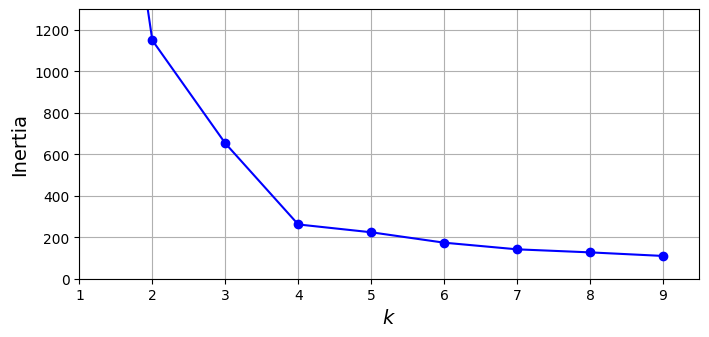

In [64]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 9.5, 0, 1300])
plt.grid()

plt.show()

We can easily identfy the elbow:

  
<img width=60% src="img/inertia_vs_k_plot.png"> 

- As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. 
- So $k=4$ is a pretty good choice. 
- Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.  
  
<img width=60% src="img/clusters_k4.png"> 


- Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. 
- An instance's **silhouette coefficient** is equal to $(b - a) / max(a, b)$ 
  - where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_)
  - and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). 
- The silhouette coefficient can vary between -1 and +1: 
  - a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, 
  - a coefficient close to 0 means that it is close to a cluster boundary
  - a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [65]:
from sklearn.metrics import silhouette_score

In [66]:
silhouette_score(X, kmeans.labels_) # X = all instances in the dataset, kmeans.labels_ = corresponding cluster labels

0.655517642572828

Let’s compare the silhouette scores for different numbers of clusters:

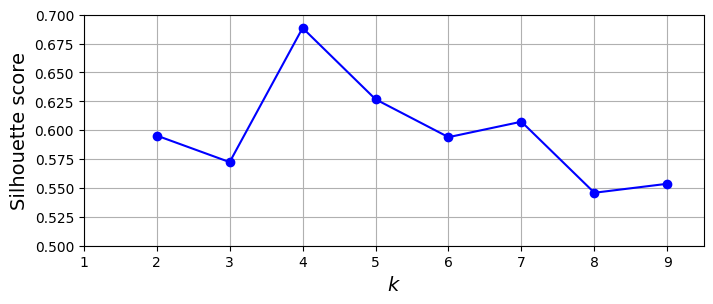

In [67]:

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]  # starting with k = 2

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.0, 9.5, 0.5, 0.7])
plt.grid()
plt.show()

In [68]:
print(silhouette_scores)

[0.5953628624305034, 0.5723900247411775, 0.688531617595759, 0.6267891051050735, 0.5939826924531691, 0.6073764342983768, 0.5458573941676348, 0.553632752836704]


In [69]:
best_index = np.argmax(silhouette_scores)
print(best_index)
k_range = range(1, 10)
best_k = k_range[best_index] + 1
print(best_k)
best_score = silhouette_scores[best_index]
print(best_score)

2
4
0.688531617595759


In [70]:
print(best_k)

4


As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

## Limits of K-Means

Let's generate a more difficult dataset, with elongated blobs and varying densities, and show that K-Means struggles to cluster it correctly:     
<img width=60% src="img/bad_kmeans_plot.png">  

- As you can see, neither of these solutions is any good. 
- The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. 
- The solution on the right is just terrible, even though its inertia is lower. 
- So, depending on the data, different clustering algorithms may perform better. 
- On these types of elliptical clusters, _Gaussian mixture_ (see further) models work great.

## Using Clustering for Image Segmentation

Take a look af the following ladybug image:    

<img width=40% src="img/ladybug.png">  

In [71]:
import PIL
filepath = "img/ladybug.png"
image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

533 pixels  high, 800 pixels wide, 3 color channels.

In [72]:
X = image.reshape(-1, 3)  # reshape to a 2D array with 3 columns (R,G,B)
print("X.shape = ")
print(X.shape)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10).fit(X)
print("8 cluster centers = ")
print(kmeans.cluster_centers_)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
print("first 10 pixels of segmented image before reshape (img replace by center)= ")
print(segmented_img[:10,:])
segmented_img = segmented_img.reshape(image.shape)
print("first 10 pixels of segmented image after reshape to original shape = ")
print(segmented_img[:10,:])

X.shape = 
(426400, 3)
8 cluster centers = 
[[  5.6105612   27.61743918   1.44857047]
 [250.68280046 237.8319458    6.51237711]
 [ 54.37997208  97.09151272  14.07131629]
 [155.1122467  160.29920705  98.37997063]
 [ 93.53208815 132.47927103  39.06947451]
 [ 24.39502109  63.41611633   4.09118396]
 [195.12454743  50.81607531  11.20057929]
 [223.40683449 182.94424185   9.39848253]]
first 10 pixels of segmented image before reshape (img replace by center)= 
[[ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]
 [ 5.6105612  27.61743918  1.44857047]]
first 10 pixels of segmented image after reshape to original shape = 
[[[  5.6105612   27.61743918   1.44857047]
  [  5.6105612   27.61743918   1.448570

The images below compare the original image with it's replacement by the center in case of 10, 8, 6, 4, 2 centers. 

How many different colors at most do we have have in the original image? 

<img width=75% src="img/image_segmentation_plot.png">  

## Using Clustering for Semi-Supervised Learning

Another use case for clustering is semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [73]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [74]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [75]:
log_reg.score(X_test, y_test)

0.7581863979848866

- The model’s accuracy is just 75.8%. 
- That’s not great: indeed, if you try training the model on the full training set, you will find that it will reach about 91% accuracy:

In [76]:
# extra code – measure the accuracy when we use the whole training set
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

- Let's see how we can do better. 
- First, let's cluster the training set into 50 clusters.
- Then for each cluster let's find the image closest to the centroid. 
- We will call these images the representative images:

In [77]:
import numpy as np
from sklearn.cluster import KMeans
k = 50
kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
X_digits_dist = kmeans.fit_transform(X_train) # array with distances to each cluster center for whole training set
representative_digit_idx = X_digits_dist.argmin(axis=0)  # cluster label for each training instance
X_representative_digits = X_train[representative_digit_idx] # array with representative digits for each cluster

Now let's plot these representative images and label them manually:

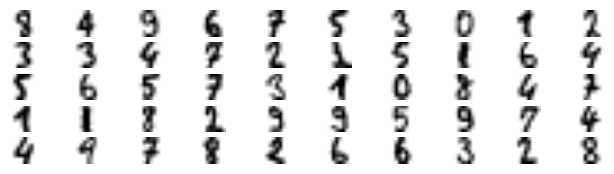

In [78]:
# extra code – this cell generates and saves Figure 9–13
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

We now set manually the labels for each representative digit

In [79]:
y_representative_digits = np.array([
    8,4,9,6,7,5,3,0,1,2,
    3,3,4,7,2,1,5,1,6,4,
    5,6,5,7,3,1,0,8,4,7,
    1,1,8,2,9,9,5,9,7,4,
    4,9,7,8,2,6,6,3,2,8
])  

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [80]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

Wow! We jumped from 75.8% accuracy to 83.9%, although we are still only training the model on 50 instances. 
  
Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [81]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [82]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [83]:
log_reg.score(X_test, y_test)

0.8589420654911839

- We got another significant accuracy boost! 
- Note we labeled manually only 50 instances from a total of 1400, the rest was labeled automatically. 

#### Active Learning

To continue improving your model and your training set, the next step could be to do a few rounds of active learning, which is when **a human expert interacts with the learning algorithm, providing labels for specific instances when the algorithm requests them**. 
There are many different strategies for active learning, but one of the most common ones is called uncertainty sampling. 
Here is how it works:
1. The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.
2. The instances for which the model is most uncertain (i.e., where its estimated probability is lowest) are given to the expert for labeling.
3. You iterate this process until the performance improvement stops being worth the labeling effort.

 
Other active learning strategies include 
- labeling the instances that would result in the largest model change 
  or 
- the largest drop in the model’s validation error
  or 
- the instances that different models disagree on (e.g., an SVM and a random forest).

## DBSCAN

This algorithm defines clusters as continuous regions of high density. 

* For each instance, the algorithm counts how many instances are located within
a small distance ε (epsilon) from it. This region is called the instance’s ε-
neighborhood.
* If an instance has at least min_samples instances in its ε-neighborhood (including
itself), then it is considered a core instance. In other words, core instances are
those that are located in dense regions.
* All instances in the neighborhood of a core instance belong to the same cluster.
This neighborhood may include other core instances; therefore, a long sequence
of neighboring core instances forms a single cluster.
* Any instance that is not a core instance and does not have one in its neighborhood
is considered an anomaly.   

This algorithm works well if all the clusters are well separated by low-density regions.
Let's try it on the moons dataset

In [84]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

,eps,0.05
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


Just take a look at the left image.   
- DBSCAN identified quite a lot of anomalies (red crosses), plus seven different clusters (visualized by different colors). How disappointing!
- Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get the clustering on the right, which looks perfect.   
   
- DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape.   
- It is robust to outliers, and it has just two hyperparameters (eps and min_samples).  
- If the density varies significantly across the clusters, or if there’s no sufficiently low-density region around some clusters, DBSCAN can struggle to capture all the clusters properly. Moreover, its computational complexity is roughly $O(m^2n)$, so it does not scale well to large datasets.   

<img width=60% src="img/dbscan_plot.png">  

There are a few other clustering algorithms that you should have at least heard before and that are also available in Scikit-Learn.  

* Agglomerative clustering connects the nearest pair of clusters (starting from indiviual instances)   
* BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) for very large datasets   
* Mean-Shift shifts circles in the direction of higher density but it is not suited for large datasets
* Affinity propagation is similar to k-means but you don’t have to pick a number of clusters ahead of time but also not suited for large datasets   
* Spectral clustering takes a similarity matrix, reduces the matrix’s dimensionality and uses another clustering algorithm in this low-dimensional space 

# Gaussian Mixtures

- Another clustering algorithm is Gaussian mixture models, which can be used for density estimation, clustering, and anomaly detection.
- A Gaussian mixture model (GMM) is a probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. 
- All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid.   
- Each cluster can have a different ellipsoidal shape, size, density, and orientation. 
- There are several GMM variants. 
- In the simplest variant, implemented in the GaussianMixture class, you must know in advance the number $k$ of Gaussian distributions.

Let's generate a dataset with three ellipsoids (K-Means had trouble with this dataset):

In [85]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [86]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


Let's look at the parameters that the algorithm estimated:

In [87]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

- Two of the three clusters were generated with 500 instances each, while the third cluster only contains 250 instances. 
- So the true cluster weights are 0.4, 0.4, and 0.2, respectively, and that’s roughly what the algorithm found.

Did the algorithm actually converge?

In [88]:
gm.converged_

True

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [89]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], shape=(1250,))

In [90]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]], shape=(1250, 3))

This is a generative model, so you can sample new instances from it (and get their labels):

In [91]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [92]:
y_new

array([0, 0, 1, 1, 1, 2])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

<img width=60% src="img/gaussian_mixtures_plot.png">  

## Anomaly Detection Using Gaussian Mixtures

- Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. 
- You must define what density threshold you want to use. 
- For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. 
- Say it is equal to 2%, then you can set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density:

In [93]:
densities = gm.score_samples(X)
print(densities)
density_threshold = np.percentile(densities, 2)
print(density_threshold)
anomalies = X[densities < density_threshold]
anomalies

[-2.60786904 -3.57094519 -3.3302143  ... -3.51359636 -4.39793229
 -3.80725953]
-5.936523002717041


array([[ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965],
       [-1.74680316, -0.78385111],
       [ 0.53903026,  5.00244257],
       [-0.51480414, -2.16270124],
       [-1.79651788, -0.97031471],
       [-3.39408574, -2.28378778],
       [ 1.58082729,  4.20122873],
       [-2.06317379,  2.2670332 ],
       [-2.54004484, -2.8290338 ],
       [-1.93037427, -1.19447352],
       [-0.27124433, -1.86750177],
       [-1.93315582,  2.49030105],
       [ 5.80546094, -0.85297906],
       [ 5.68060531,  0.20598784],
       [ 3.55103259,  3.47752824],
       [ 5.5515503 ,  2.76962697],
       [ 4.00585006,  4.86701762],
       [ 3.22614554,  3.73445529],
       [ 5.61295857,  2.04675139],
       [ 5.62383575, -0.93780167],
       [ 2.30754386, -1.02494605],
       [ 6.56968319,  2.13386104],
       [ 3.21575068, -1.28763504],
       [ 4.07765947,  3.20474175]])

Anomalies are the red crosses:


<img width=60% src="img/mixture_anomaly_detection_plot.png">  